In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from glob import glob
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from model import Deeplabv3

In [14]:
# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 1:
    try:
        print("Activate Multi GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    except RuntimeError as e:
        print(e)

else:
    try:
        print("Activate Sigle GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
        strategy = tf.distribute.experimental.CentralStorageStrategy()
    except RuntimeError as e:
        print(e)

Activate Sigle GPU
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'


In [15]:
def get_file_list(path):
    images = sorted(glob(f"{path}/images/*.jpg"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    
    n_images, n_masks = len(images), len(masks)
    
    return images, masks, n_images, n_masks


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])

    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        # image = image / 127.5 - 1

    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)

    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)

    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)

    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)

    return overlay


def plot_samples_matplotlib(display_list, idx, figsize=(5, 3)):
    if not os.path.isdir("./train_result"):
        os.makedirs("./train_result")

    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])

    plt.savefig(f"./train_result/result_{idx}.png")
    plt.show()
    plt.close()


def plot_predictions(images_list, colormap, model):
    for idx, image_file in enumerate(images_list):
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], idx, figsize=(18, 14))

In [17]:
def display_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig(f"./train_result/train_history.png")
    # plt.show()
    plt.close()


def get_images(masks):
    image_files = []
    for mask in masks:
        file_name = mask.split('/')[-1].split('.')[0]
        if os.path.isfile(f"{images}/{file_name}.jpg"):
            image_files.append(f"{images}/{file_name}.jpg")

    return image_files


In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        
        # idx = np.random.randint(len(valid_images))
        # plot_predictions([valid_images[idx]], colormap, model=model)
        
        plot_predictions(valid_images[:4], COLORMAP, model=model)

In [19]:
ROOT = "/data/Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"
LABEL_PATH = f"{ROOT}/Labels/class_labels.txt"
SAVE_PATH = "/data/Models/segmentation-sample"
IS_SPLIT = True
FOLDER = "Augmentation-sample"

In [20]:
BATCH_SIZE = 16
EPOCHS = 100
IMG_SIZE = 320
LEARNING_RATE = 0.0001

label_df = pd.read_csv(LABEL_PATH, lineterminator="\n", header=None, index_col=False)
CLASSES = label_df[0].to_list()
NUM_CLASSES = len(CLASSES)
print(CLASSES)

COLORMAP = [[0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128]]
COLORMAP = np.array(COLORMAP, dtype=np.uint8)

['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


In [21]:
if not IS_SPLIT:
    root = f"{ROOT}/{FOLDER}"
    train_dir = f"{root}/train"
    valid_dir = f"{root}/valid"

    train_images, train_masks, n_train_images, n_train_masks = get_file_list(train_dir)
    valid_images, valid_masks, n_valid_images, n_valid_masks = get_file_list(valid_dir)

else:
    root = f"{ROOT}"
    masks = sorted(glob(f"{root}/SegmentationRaw/*.png"))
    images = f"{root}/JPEGImages"

    images = get_images(masks)
    print(len(images), len(masks))

    train_images, valid_images, train_masks, valid_masks = train_test_split(images, masks, test_size=0.1, shuffle=True, random_state=42)
    print(len(train_images), len(train_masks))
    print(len(valid_images), len(valid_masks))

2913 2913
2621 2621
292 292


In [22]:
train_dataset = data_generator(train_images, train_masks)
valid_dataset = data_generator(valid_images, valid_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", valid_dataset)

Train Dataset: <PrefetchDataset shapes: ((16, 320, 320, 3), (16, 320, 320, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <PrefetchDataset shapes: ((16, 320, 320, 3), (16, 320, 320, 1)), types: (tf.float32, tf.float32)>


In [23]:
### weights : "pascal_voc", "cityscapes", None
# model = Deeplabv3(weights="pascal_voc", input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=len(CLASSES), backbone='xception', OS=16, alpha=1., activation=None)
model = Deeplabv3(weights="cityscapes", input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=len(CLASSES), backbone='xception', OS=16, alpha=1., activation=None)
model.summary()

for layer in model.layers:
    layer.trainable = True
    # print(layer.name + ": " + str(layer.trainable))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=["accuracy"])
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9), loss=loss, metrics=["accuracy"])

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 160, 160, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 160, 160, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 160, 160, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

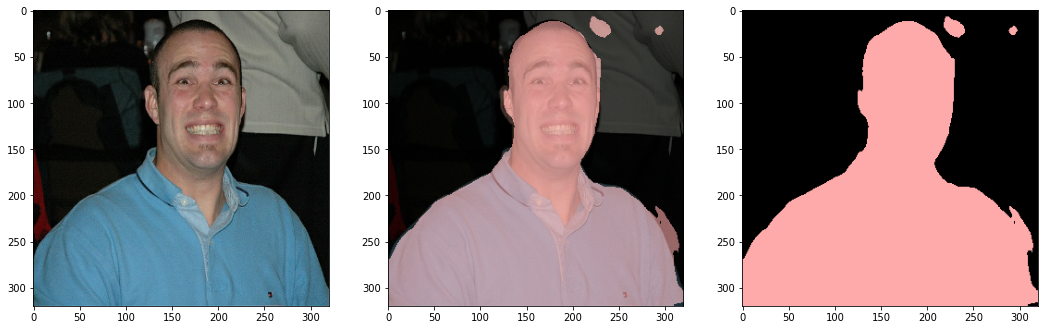

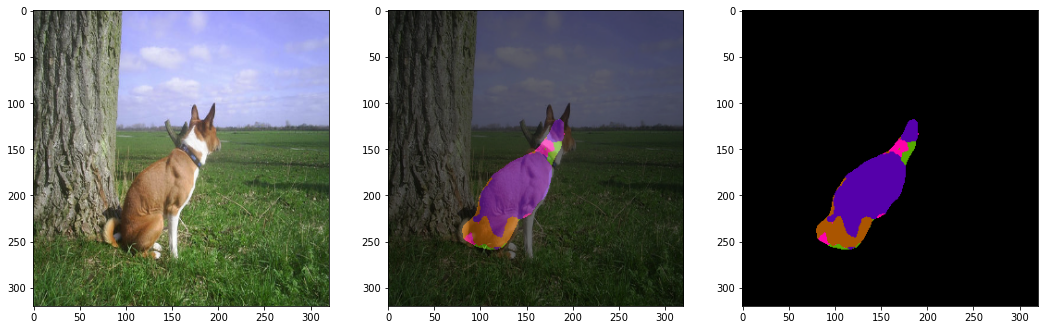

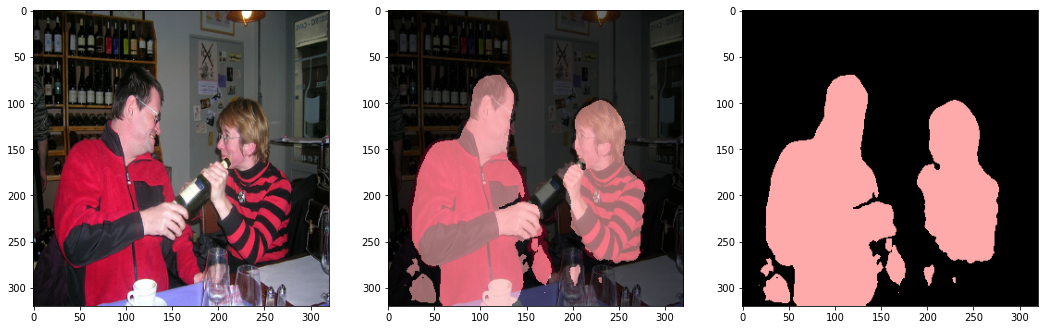

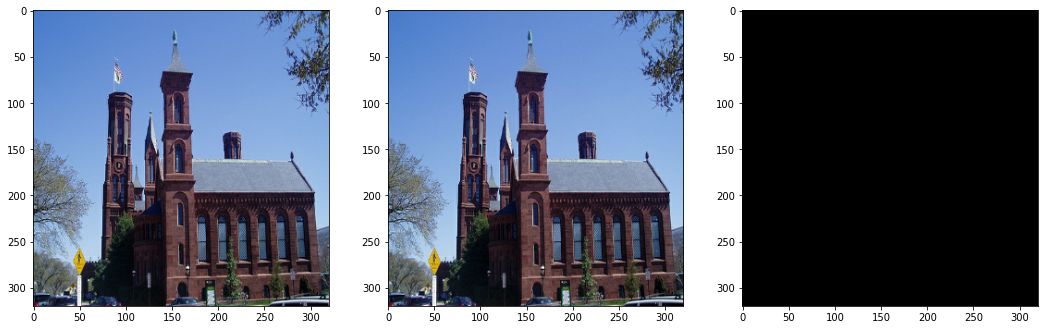


Epoch 00002: val_loss improved from 0.88956 to 0.53296, saving model to /data/Models/segmentation-sample/saved_model/deeplabv3+.ckpt
Epoch 3/100
  9/164 [>.............................] - ETA: 1:12 - loss: 0.3706 - accuracy: 0.9140

KeyboardInterrupt: 

In [24]:
TRAIN_STEPS_PER_EPOCH = int(tf.math.ceil(len(train_images) / BATCH_SIZE).numpy())
VALID_STEPS_PER_EPOCH = int(tf.math.ceil(len(valid_images) / BATCH_SIZE).numpy())

callbacks = [DisplayCallback(),
             tf.keras.callbacks.ModelCheckpoint(f"{SAVE_PATH}/saved_model/deeplabv3+.ckpt", 'val_loss', verbose=1, save_best_only=True, save_weights_only=True)]
            
history = model.fit(train_dataset,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS_PER_EPOCH,
                    callbacks=callbacks,
                    verbose=1,
                    epochs=EPOCHS)

In [ ]:
display_training_curves(history)

In [ ]:
model = Deeplabv3(weights=None, input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=len(CLASSES), backbone='xception', OS=8, alpha=1., activation=None)
model.load_weights(f"{SAVE_PATH}/saved_model/deeplabv3+.ckpt")

In [ ]:
plot_predictions(valid_images[:4], COLORMAP, model=model)

In [ ]:
run_model = tf.function(lambda x : model(x))
batch_size = 1
input_size = IMG_SIZE

concrete_func = run_model.get_concrete_function(tf.TensorSpec([batch_size, input_size, input_size, 3], model.inputs[0].dtype))

In [ ]:
# tf.saved_model.save(model, f'{SAVE_PATH}/saved_model')
tf.saved_model.save(model, f'{SAVE_PATH}/saved_model', signatures=concrete_func)